[*********************100%***********************]  2 of 2 completed


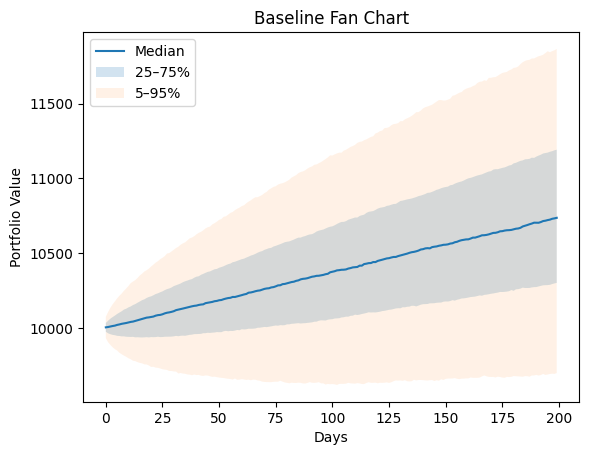

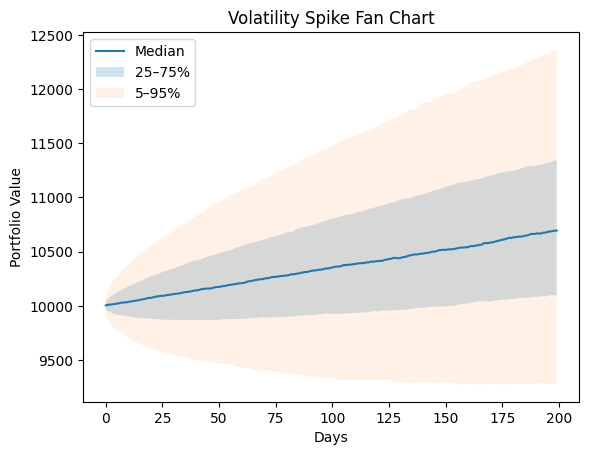

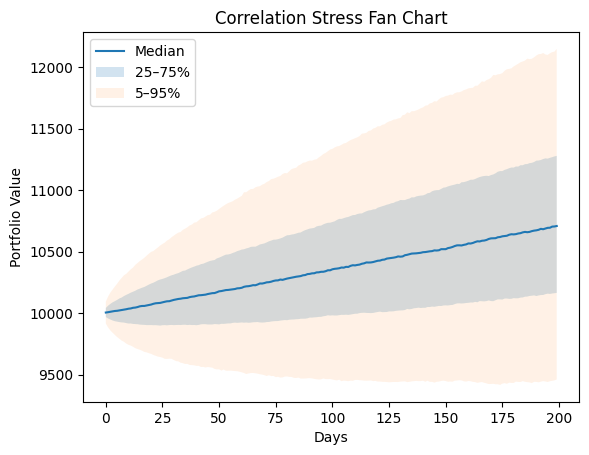

                    Expected Final Value[V_t]  Std(V_t)  VaR 5% (final value)
Baseline                             10757.79    668.12               9697.40
Volatility Spike                     10742.58    941.41               9279.29
Correlation Stress                   10741.95    825.59               9460.00


In [11]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

#----------------------------------------------------------------------------------------------------------------------------------------

# Reusable function to get stock data
def get_data(stocks,start,end):
    stockData = yf.download(stocks, start, end) # Fetches data from Yahoo Finance

    stockData = stockData['Close'] # We only need closing prices
    returns = stockData.pct_change() # Calculates daily returns
    meanReturns = returns.mean() # Mean of daily returns
    covMatrix = returns.cov() # Covariance matrix of returns

    return meanReturns, covMatrix 


#----------------------------------------------------------------------------------------------------------------------------------------


# Reusable function to perform Monte Carlo Simulation

def Monte_Carlo_Simulation(meanReturns, covMatrix, weights, T, sims, intialPortfolio):

    # Create mean returns matrix
    meanM = np.full(shape = (T,len(weights)),fill_value = meanReturns)
    meanM = meanM.T


    # Create empty matrix to store portfolio value simulations
    portfolio_sims = np.full(shape = (T,sims),fill_value = 0.0)

    # Cholesky Decomposition 
    L = np.linalg.cholesky(covMatrix)

   
    for m in range(sims):

        # Generate independant random correlated daily returns
        Z = np.random.normal(size = (len(weights),T))   

        # Generate correlated daily returns
        dailyReturns = meanM + (L @ Z)                  

        # Calculate portfolio value over time
        portfolio_sims[:,m] = np.cumprod(np.inner(weights,dailyReturns.T)+1)  * intialPortfolio 

    return portfolio_sims

#----------------------------------------------------------------------------------------------------------------------------------------


tickers = ["SPY", "IEF"] # S&P 500 ETF and 7-10 Year Treasury ETF
start = "2023-01-01" 
end = dt.datetime.now() 


meanReturns, covMatrix = get_data(tickers, start, end) # Get mean returns and covariance matrix

weights = np.array([0.7, 0.3])  # Portfolio Weights: 70% SPY, 30% IEF

sims = 10000 
T = 200 #time frame in days
initialPortfolio = 10000 # Initial Portfolio Value

#----------------------------------------------------------------------------------------------------------------------------------------

# Scenario A: Baseline
baseline_portfolio_sims = Monte_Carlo_Simulation(meanReturns, covMatrix, weights, T, sims, initialPortfolio)



# Scenario B: Volatility spike (2x risk)
vol_multiplier = 2.0
cov_vol = vol_multiplier * covMatrix  
sims_vol = Monte_Carlo_Simulation(meanReturns, cov_vol, weights, T, sims, initialPortfolio)



# Scenario C: Correlation stress (push correlations higher)
vols = np.sqrt(np.diag(covMatrix))  # Volatilities
corr = covMatrix / np.outer(vols, vols) # Convert covariance to a correlation matrix

target_rho = 0.8 # Realistic but stressed target correlation as diversification breaks down

# Builds stress scenario correlation matrix
corr_target = np.full_like(corr, target_rho)
np.fill_diagonal(corr_target, 1.0) 

alpha = 0.7  # 0 = no stress, 1 = fully target correlation
corr_stress = (1 - alpha) * corr + alpha * corr_target # Weighted average

cov_corr = corr_stress * np.outer(vols, vols) # Convert back to covariance matrix
sims_corr = Monte_Carlo_Simulation(meanReturns, cov_corr, weights, T, sims, initialPortfolio)

#----------------------------------------------------------------------------------------------------------------------------------------

#“To model correlation stress, the historical correlation matrix was blended with a crisis-style target correlation matrix in which off-diagonal elements were set to 0.8. This target level reflects empirical observations that asset correlations tend to increase substantially during periods of market stress. A blending parameter of α = 0.7 was chosen to represent a severe but plausible deterioration in diversification, while avoiding the assumption of a fully collapsed correlation structure. This approach allows the isolation of correlation-driven risk amplification without altering individual asset volatilities.”




# Reusable Fan chart function

def fan_chart(portfolio_sims, title):

    # Calculate percentiles
    p5  = np.percentile(portfolio_sims, 5, axis=1)
    p25 = np.percentile(portfolio_sims, 25, axis=1)
    p50 = np.percentile(portfolio_sims, 50, axis=1)
    p75 = np.percentile(portfolio_sims, 75, axis=1)
    p95 = np.percentile(portfolio_sims, 95, axis=1)

    # Plot fan chart
    plt.figure()
    plt.plot(p50, label="Median")
    plt.fill_between(range(len(p50)), p25, p75, alpha=0.2, label="25–75%")
    plt.fill_between(range(len(p50)), p5, p95, alpha=0.1, label="5–95%")
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.show()

# Generate fan charts for each scenario
fan_chart(baseline_portfolio_sims, "Baseline Fan Chart")
fan_chart(sims_vol,  "Volatility Spike Fan Chart")
fan_chart(sims_corr, "Correlation Stress Fan Chart")




# Reusable function to compute key metrics
def compute_metrics(portfolio_sims):
    ending_values = portfolio_sims[-1, :]
    mean_end = np.mean(ending_values)           
    std_end = np.std(ending_values)
    var_95 = np.percentile(ending_values, 5)

    return {
        "Expected Final Value[V_t]": mean_end,
        "Std(V_t)": std_end,
        "VaR 5% (final value)": var_95
    }



# Compute metrics for each scenario
metrics_base = compute_metrics(baseline_portfolio_sims)
metrics_vol  = compute_metrics(sims_vol)
metrics_corr = compute_metrics(sims_corr)


# Combine metrics into a table
results_table = pd.DataFrame.from_dict(
    {
        "Baseline": metrics_base,
        "Volatility Spike": metrics_vol,
        "Correlation Stress": metrics_corr
    },
    orient="index"
)


results_table = results_table.round(2)
print(results_table)

Table 1 reports summary statistics of simulated terminal portfolio values under baseline, volatility spike, and correlation stress scenarios. Expected final values remain broadly stable across scenarios, reflecting unchanged return assumptions. However, downside risk increases materially under stress. In particular, correlation stress reduces the 5% VaR from 9,695 to 9,421, demonstrating the deterioration of diversification benefits even when individual asset volatilities are unchanged.

Stress scenarios don’t change what you expect to earn — they change how bad things can get.